___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 


# TERCER EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Nombre: Diego Pintor Ochoa

## Fecha: 12 de mayo del 2021

## Por: Oscar David Jaramillo Z.

# 1
Vamos a suponer que el curso de simulación de procesos financieros es una gran empresa de consultoría financiera que ofrece sus servicios a cualquier tipo de compañía o particular. Supongamos que acuden a nuestra empresa 4 personalidades con los siguientes problemas que desean solucionar:
> 1. El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 
> 2. La segunda empresa, es una empresa que construye productos en aluminio que tiene 1 año de estar ejerciendo en este tipo mercado. El gerente desea crear un plan de acción para expandir la empresa realizando estrategias financieras que le permitan maximizar sus ganancias y de esta forma cumplir con el objetivo planteado.
> 3. El tercer cliente, es una empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.
> 4. Nuestro último cliente, es la empresa mexicana PEMEX, que desea ejecutar ciertas estrategias financieras, que les permita cubrirse ante posibles caídas en el precio del barril del petróleo. Su objetivo en maximizar sus ganancias y minimizar las pérdidas de la compañía usando la mejor estrategia financiera (costo-beneficio).

Para cada uno de los clientes, se debe de presentar 3 posibles estrategias de cobertura usando opciones Europeas, Asiáticas y barrera tipo call ó put. Además de ofrecer al cliente este abanico de posibilidades, ustedes como analistas financieros deben de recomendar la mejor estrategia costo-beneficio (basado en sus cálculos), que debería cada empresa tomar, para cumplir con su objetivo. Recuerden, pueden asumir diversos escenarios donde con la valuación realizada para cada una de sus opciones, puedan ustedes dar un estimado monetario en dos posibles escenarios. Por ejemplo, si pueden ejercer la opción entonces el cliente además de vender o comprar sus productos obtendrá una cantidad X de ganancias adicionales o en lugar de perder un 50% de los ingresos en sus ventas, el empresario puede perder sólo el 10% de los ingresos de sus ventas. Por el contrario, en el caso que no ejerza su opción el cliente tendrá una pérdida de la prima de la cantidad de opciones compradas (pero recalcando que el empresario puede estar cubierto ante diversas situaciones). La calificación será basada en el análisis que realicen y propongan a cada cliente usando los resultados de sus valuaciones.

**Para la valuación de opciones europeas debes de comparar tu valuación usando montecarlo con el valor teórico dado por el modelo de Black and Scholes dado en clase y concluir,**

> ###  Criterio de evaluación
> - Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.
> - **Ejercicio 1**: 40% La valuación de cada tipo de opción corresponderá al 40% de todo este examen.
> - **Ejercicio 2**: 60%. El restante 60% corresponderá a la decisión o recomendación basado en sus análisis que le recomendarán a cada compañía.

> ### Entrega
> Se debe de entregar un cuaderno de python donde se reporten todos los cálculos empleados en su análisis. La fecha límite de entrega será el miércoles 12 de mayo a las 5 pm y se expondrá ese mismo día los resultados obtenidos.

> ### Suposiciones 
> - Deben de definirse correctamente el nombre de las acciones a descargar de Yahoo según la empresa asignada.
> - El examen es individual y códigos idénticos serán penalizados.


In [1]:
# Importando librerías
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy.stats import norm
%matplotlib inline
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

# Cálculo de los log-rendimientos
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [2]:
# Funciones para calcular opciones Europeas
def euroCall(r,closes,strike,expiry):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(closes - strike, 0)
                     .mean(axis=1)},index=dates)
    return call
    
def euroPut(r,closes,strike,expiry):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - closes, 0)
                     .mean(axis=1)},index=dates)
    return put
def blackScholesPut(strike,S0,r,sigma,expiry):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    T = len(dates)/360
    r = r*360
    sigma = sigma*np.sqrt(252)
    d1 = (np.log(S0/strike)+(r+sigma**2/2)*T)/sigma*np.sqrt(T)
    d2 = d1 - sigma*np.sqrt(T)
    put = strike*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1) 
    return put    
    
def blackScholesCall(strike,S0,r,sigma,expiry):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    T = len(dates)/360
    r = r*360
    sigma = sigma*np.sqrt(252)
    d1 = (np.log(S0/strike)+(r+sigma**2/2)*T)/sigma*np.sqrt(T)
    d2 = d1 - sigma*np.sqrt(T)
    call = S0*norm.cdf(d1) - strike*np.exp(-r*T)*norm.cdf(d2)
    return call

In [3]:
# Funciones para valuación de opciones asiáticas
def asiaticaPut(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',expiry,
                    flag=None):
    def BSprices(mu,sigma,S0,NbTraj,NbStep):
        """
        Expresión de la solución de la ecuación de Black-Scholes
        St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)

        Parámetros
        ---------
        mu    : Tasa libre de riesgo
        sigma : Desviación estándar de los rendimientos
        S0    : Precio inicial del activo subyacente
        NbTraj: Cantidad de trayectorias a simular
        NbStep: Número de días a simular
        """
        # Datos para la fórmula de St
        nu = mu-(sigma**2)/2
        DeltaT = 1/NbStep
        SqDeltaT = np.sqrt(DeltaT)
        DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)

        # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
        increments = nu*DeltaT + sigma*DeltaW
        concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)

        # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
        LogSt = np.cumsum(concat,axis=1)
        # Se obtienen los precios simulados para los NbStep fijados
        St = np.exp(LogSt)
        # Vector con la cantidad de días simulados
        t = np.arange(0,NbStep)

        return St.T,t
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=dates)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima_asiatica': np.exp(-r*T) \
                 *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=dates)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima_asiatica
    mean_est = put.iloc[-1].Prima_asiatica
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    return put, i1

def asiaticaCall(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',expiry,
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    def BSprices(mu,sigma,S0,NbTraj,NbStep):
        """
        Expresión de la solución de la ecuación de Black-Scholes
        St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)

        Parámetros
        ---------
        mu    : Tasa libre de riesgo
        sigma : Desviación estándar de los rendimientos
        S0    : Precio inicial del activo subyacente
        NbTraj: Cantidad de trayectorias a simular
        NbStep: Número de días a simular
        """
        # Datos para la fórmula de St
        nu = mu-(sigma**2)/2
        DeltaT = 1/NbStep
        SqDeltaT = np.sqrt(DeltaT)
        DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)

        # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
        increments = nu*DeltaT + sigma*DeltaW
        concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)

        # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
        LogSt = np.cumsum(concat,axis=1)
        # Se obtienen los precios simulados para los NbStep fijados
        St = np.exp(LogSt)
        # Vector con la cantidad de días simulados
        t = np.arange(0,NbStep)

        return St.T,t
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=dates)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima_asiatica': np.exp(-r*T) \
                 *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=dates)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima_asiatica
    mean_est = call.iloc[-1].Prima_asiatica
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    return call, i1


In [4]:
# funciones para valuación de opciones barrera

def putDownAndOut(r,closes,strike,expiry,B):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    I = (closes > B).cumprod(axis=0)  > 0
    putuo = pd.DataFrame({'Prima Down-and-out':np.exp(-r*ndays)*(I * np.fmax(strike - closes, 0))
                       .mean(axis=1)},index=dates)
    return putuo
def callUpAndOut(r,closes,strike,expiry,B):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    I = (closes < B).cumprod(axis=0)  > 0
    calldo = pd.DataFrame({'Prima Up-and-out':np.exp(-r*ndays)*(I * np.fmax(closes - strike, 0))
                       .mean(axis=1)},index=dates)
    return calldo

In [5]:
# Función para simular cierres de activo
#S0 = closes_appl.iloc[-1]
def sim_closes(N,expiry,S0,r,sigma,):
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    nscen = N
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    return sim_closes

In [6]:
# Función para generar volatilty smile para seleccionar strike
def vol_smile(tick,exp,tipo):
    today = pd.Timestamp(date.today())
    pd.set_option('display.max_rows', 10)
    op = web.YahooOptions(tick)
    opt = op.get_all_data().reset_index()
    opt.set_index('Expiry').sort_index()#.head(1000)
    opcion = opt.loc[(opt.Expiry== exp) & (opt.Type==tipo)]
    ax = opcion.set_index('Strike').loc[:, 'IV'].plot(figsize=(8,6))
    ax.axvline(opcion.Underlying_Price.iloc[0], color='g');
    valor = opcion.Underlying_Price.iloc[0]
    return valor

# 1. Granjero que cultiva maíz (opción que le da derecho a vender un activo, put)

Para ayudar a cubrir a este granjero, se selecciona la opción Put, que da el derecho, más no la obligación a vender un activo subyacente a un precio pactado. En este caso, el granjero desea cubrirse ante una bajada de los precios del maíz, por lo que el precio pactado para ejercer la opción será el mismo precio spot al que se encuentra el día de hoy (opción at-the-money).

El activo sobre el cuál se armarán las opciones tomará como referencia el precio de los futuros del Maíz, ticker de instrumento *ZC=F*.


In [75]:
# Requisitos para armar una estrategia completa de opciones europeas usando las funciones anteriores
# Ticker
tick_1 = "ZC=F"
fecha_inicio = "2017-01-01"
fecha_fin = date.today() 
closes_1 = get_adj_closes(tick_1,fecha_inicio,fecha_fin)
ret_1 = calc_daily_ret(closes_1)
sigma_1 = ret_1.std()
r = 0.0005/360


In [76]:
# Simulación de cierres diario
expiracion = "2021-12-21"
S0_1 = closes_1.iloc[-1]
simul_1 = sim_closes(10000,expiracion,S0_1,r,sigma_1)
S0_1

725.75

El precio spot y el precio de ejercicio será de $725.75.


In [79]:
# Valuando opción
strike_1 = S0_1
put_maiz = euroPut(r,simul_1,strike_1,expiracion)

Prima Europea    46.263
Name: 2021-12-21 00:00:00, dtype: float64

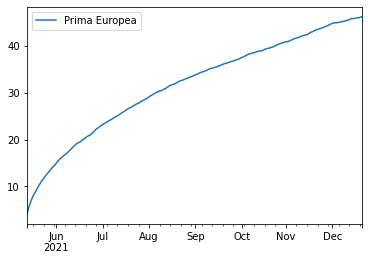

In [80]:
put_maiz.plot()
put_maiz.iloc[-1]

### Valuando la opción europea usando Black-Scholes


In [81]:
blackScholesPut(strike_1,S0_1,r,sigma_1,expiracion)

42.98294589276827

### Valuación asiática de opción


((35.448857707111756, 38.20964307211567),
 Prima_asiatica    36.829
 Name: 2021-12-21 00:00:00, dtype: float64)

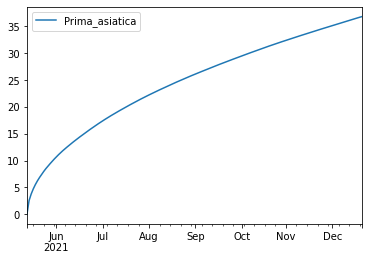

In [82]:
asianPut_1,intervalo = asiaticaPut(strike_1,r*360,S0_1,10000,160,sigma_1*np.sqrt(252),160/360,expiracion)
asianPut_1.plot();
intervalo,asianPut_1.iloc[-1]

### Valuación Opción Barrera Put

(Prima Down-and-out    28.729
 Name: 2021-12-21 00:00:00, dtype: float64,
 544.3125)

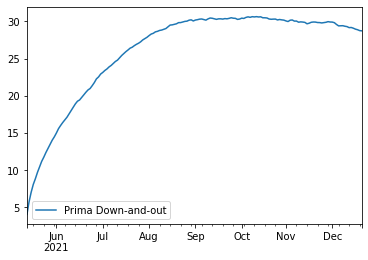

In [84]:
B_1 = S0_1*(1-.25) #25% de pérdidas
barrera_1 = putDownAndOut(r,simul_1,strike_1,expiracion,B_1)
barrera_1.plot();
barrera_1.iloc[-1],B_1


### Comparación de las primas 

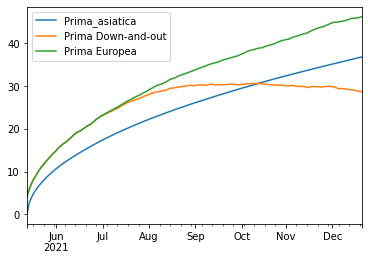

(None, [46.263161534022494, 36.82925038961371, 28.72943961621204])

In [85]:
primas_1 = [float(put_maiz.iloc[-1]),float(asianPut_1.iloc[-1]),float(barrera_1.iloc[-1])]

ax = plt.gca()
asianPut_1.plot(ax=ax)
barrera_1.plot(ax=ax)
put_maiz.plot(ax=ax)
plt.show(),primas_1

## Recomendación al granjero de maíz
Debido a que la opción barrera cotizada es una de tipo Down-And-Out (que se desactiva si el precio baja de la barrera establecida, de 542.5625 dólares por tonelada), al granjero le convendría contratar esta opción de cobertura, si se encuentra dentro de un mercado alcista. Debido a que este parece ser el caso (debido a una posible presión inflacionara derivada de los estímulos fiscales de la crisis del coronavirus), esta opción resulta la más barata de contratar, con una prima de $28.729 por opción.
La opción asiática es otra opción barata que podría desear contratar debido al descuento con respecto a la opción europea, en caso de que no pudiera tener certeza con la opción barrera por encontrarse en un mercado a la baja. Este no es el caso.

Suponiendo el escenario donde el granjero desea contratar 1000 opciones para asegurar 1000 toneladas de maíz, tendría que pagar por las opciones barrera un total de 28'729 dólares, lo cuál a un precio spot del máiz de $725.75, representa un 3.958% del valor actual del contrato (725'750 dólares). El granjero estaría pagando esta cantidad por asegurar al menos 181.4375 dólares del precio del maíz actual, un 25%.
El pago de esta opción se vería completamente cubierto si en el mercado alcista el precio del maíz sube a 754.479 dólares, lo cuál, dentro del mercado alcista del maíz es bastante probable. 

En el caso de contratarse opciones asiáticas, con una prima de 36.829 dólares, se paga el 5% del valor del contrato (36'829 dólares) para cubrir cualquier pérdida que se pueda tener en el mercado. El precio del maíz tendría que subir hasta 762.58 dólares para cubrir el pago de esta prima.

Se recomienda cubrir utilizando la opción barrera Down-And-Out, porque es poco probable que se ejerza esta opción.

# 2. Empresa que construye productos en Aluminio (opción Call, derecho de compra)

Para el segundo caso, la empresa que construye productos en aluminio, necesita comprar el aluminio para poder construir los productos, por lo cuál necesita una opción Call, la cuál consiste en el derecho, más no la obligación de comprar el activo al precio pactado en la fecha pactada. Las opciones también serán At-The-Money.

Para este caso, el instrumento sobre el cuál se cotizarán las opciones son los futuros de aluminio, insturmento *ALI=F*.

In [86]:
# Requisitos para armar una estrategia completa de opciones europeas usando las funciones anteriores
# Ticker
tick_2 = "ALI=F"
fecha_inicio_2 = "2020-05-09"
fecha_fin_2 = date.today() 
closes_2 = get_adj_closes(tick_2,fecha_inicio,fecha_fin)
ret_2 = calc_daily_ret(closes_2)
sigma_2 = ret_2.std()

In [87]:
# Simulación de cierres diarios
expiracion_2 = "2022-05-09"
S0_2 = closes_2.iloc[-1]
simul_2 = sim_closes(10000,expiracion_2,S0_2,r,sigma_2)
S0_2

2567.5

El precio de Spot y ejercicio de las opciones es de $2567.5 por tonelada

In [88]:
# Valuando opción
strike_2 = S0_2
call_alum = euroCall(r,simul_2,strike_2,expiracion_2)

Prima Europea    181.358
Name: 2022-05-09 00:00:00, dtype: float64

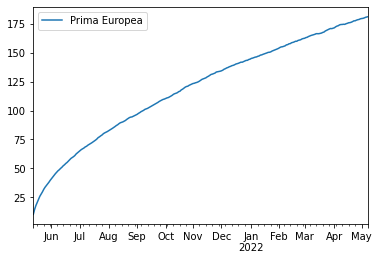

In [89]:
call_alum.plot()
call_alum.iloc[-1]

### Valuando la opción europea usando Black-Scholes

In [90]:
blackScholesCall(strike_2,S0_2,r,sigma_2,expiracion_2)

137.24906997565176

### Valuación asiática de opción

((90.61210341586981, 96.0495754612471),
 Prima_asiatica    93.331
 Name: 2022-05-09 00:00:00, dtype: float64)

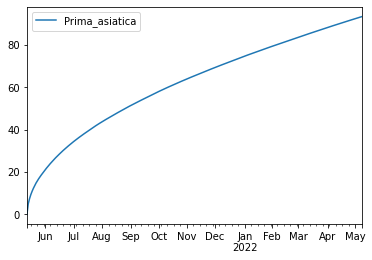

In [91]:
asianCall_2,intervalo_2 = asiaticaCall(strike_2,r*360,S0_2,10000,259,sigma_2*np.sqrt(252),259/360,expiracion_2)
asianCall_2.plot();
intervalo_2,asianCall_2.iloc[-1]

### Valuación Opción Barrera Call

(Prima Up-and-out    75.775
 Name: 2022-05-09 00:00:00, dtype: float64,
 3209.375)

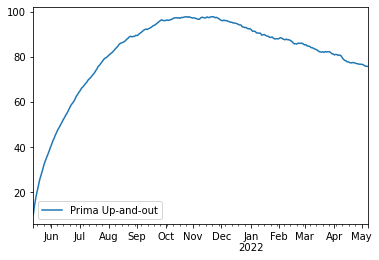

In [114]:
B_2 = S0_2*(1+.25) #25% de pérdidas
barrera_2 = callUpAndOut(r,simul_2,strike_2,expiracion_2,B_2)
barrera_2.plot();
barrera_2.iloc[-1],B_2

## Comparación de las Primas

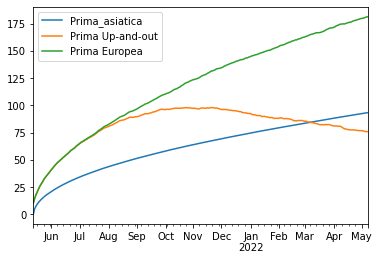

(None, [181.3575660899467, 93.33083943855846, 75.77533157485256])

In [95]:
primas_2 = [float(call_alum.iloc[-1]),float(asianCall_2.iloc[-1]),float(barrera_2.iloc[-1])]
ax = plt.gca()
asianCall_2.plot(ax=ax)
barrera_2.plot(ax=ax)
call_alum.plot(ax=ax)
plt.show(),primas_2

## Recomendación a la empresa

Se parte del hipotético caso que esta empresa que compra Aluminio, decide contratar opciones para cubrir la compra de 10 toneladas de aluminio. Con un precio Spot de 2567.5 dólares, el total del contrato es de 25'675 dólares.

La opción recomendada en este caso es una opción Up-And-Out (que si el precio del subyacente supera la barrera, la opción se desactiva) con una barrera de 3209.375 dólares (25% de pérdidas). La prima de esta barrera es de 75.77 dólares por opción, el contrato de opciones valdría 757.8 dólares (10 opciones), lo cuál representa un 2.95% del valor del contrato. Esta opción se desactivaría en caso de que el precio del subyacente subiera más allá de 3209.375 dólares, obligando al comprador a pagar el precio spot en ese momento, por pérdidas potenciales de más del 25%. Este contrato de opciones se recupera en caso de que el precio spot del aluminio baje de 2491.72 dólares (2.95%). En caso de que la inflación impacte al mercado también de este activo, o que haya una tendencia alcista, el contrato de opciones barrera cubre hasta por una subida de 641.875 dólares por tonelada.

La otra opción para cubrir este contrato sería mediante opciones asiáticas, con las que pagando con una prima de 93.33 dólares por opción, (933.3 dólares por las 10 opciones), el comprador puede cubrir cualquier pérdida debido a la subida del precio del aluminio. El valor de este contrato de opciones representa el 3.63% del valor del contrato de aluminio.

La diferencia entre la opción asiática y la opción barrera es de 17.55 dólares. La opción barrera cubre hasta por un 25%, mientras que la opción asiática cubre por más, por lo que en términos costo-beneficio, con la asiática se puede cubrir por un mayor monto de pérdidas pagando un poco más.



# 3. Empresa Joyera de piezas en Oro (opción Call)

In [96]:
# Requisitos para armar una estrategia completa de opciones europeas usando las funciones anteriores
# Ticker
tick_3 = "ZG=F"
fecha_inicio_3 = "2020-05-09"
fecha_fin_3 = date.today() 
closes_3 = get_adj_closes(tick_3,fecha_inicio,fecha_fin)
ret_3 = calc_daily_ret(closes_3)
sigma_3 = ret_2.std()

In [97]:
# Simulación de cierres diarios
expiracion_3 = "2022-05-09"
S0_3 = closes_3.iloc[-1]
simul_3 = sim_closes(10000,expiracion_3,S0_3,r,sigma_3)
S0_3

1837.800048828125

El precio spot y strike de este activo se encuentra en 1837.8 dólares por tonelada.

Prima Europea    130.336
Name: 2022-05-09 00:00:00, dtype: float64

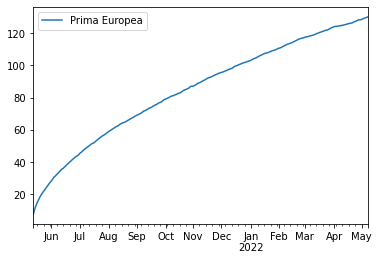

In [98]:
# Valuando opción
strike_3 = S0_3
call_oro = euroCall(r,simul_3,strike_3,expiracion_3)
call_oro.plot()
call_oro.iloc[-1]

### Valuando la opción europea usando Black-Scholes

In [99]:
blackScholesCall(strike_3,S0_3,r,sigma_3,expiracion_3)

98.24200486966595

### Valuación asiática de opción

((65.90939185525836, 69.88883672482062),
 Prima_asiatica    67.899
 Name: 2022-05-09 00:00:00, dtype: float64)

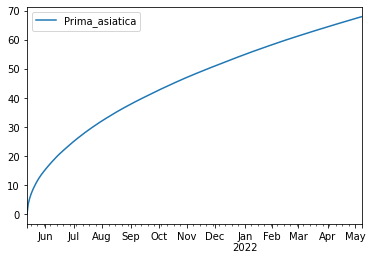

In [100]:
asianCall_3,intervalo_3 = asiaticaCall(strike_3,r*360,S0_3,10000,259,sigma_3*np.sqrt(252),259/360,expiracion_3)
asianCall_3.plot();
intervalo_3,asianCall_3.iloc[-1]

### Valuación Opción Barrera Call

(Prima Up-and-out    55.322
 Name: 2022-05-09 00:00:00, dtype: float64,
 2297.2500610351562)

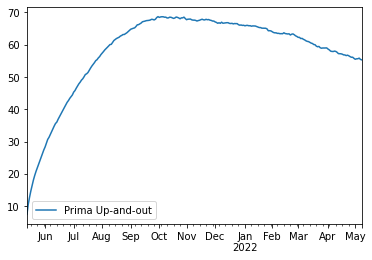

In [110]:
B_3 = S0_3*(1+.25) #25% de pérdidas
barrera_3 = callUpAndOut(r,simul_3,strike_3,expiracion_3,B_3)
barrera_3.plot();
barrera_3.iloc[-1],B_3

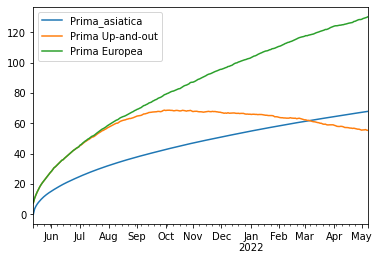

(None, [130.3362432491583, 67.89911429003949, 55.32155243786941])

In [102]:
primas_3 = [float(call_oro.iloc[-1]),float(asianCall_3.iloc[-1]),float(barrera_3.iloc[-1])]
ax = plt.gca()
asianCall_3.plot(ax=ax)
barrera_3.plot(ax=ax)
call_oro.plot(ax=ax)
plt.show(),primas_3

## Recomendación a la empresa joyera.
Para este caso hipotético, se contempla la adquisición del joyero de 10 opciones, con un precio strike igual al spot de 1837.8 dólares por opción. Cada opción representa el contrato de comprar 100 onzas de oro (2.834 kilogramos) de oro, para un total de 18'378 dólares.

Para este caso, la barrera en la opción barrera Up-And-Out (que se desactiva cuando el precio pasa de la barrera) que se estableció en 2297.25 dólares (25%), el precio de la opción sería de 55.321 dólares. El contrato de las opciones barrera de este activo representan el 3.01% del valor del contrato (553.21 dólares). El pago de esta prima se recuperaría si el precio baja de 1782.48 dólares. Esta opción cubre por una subida de hasta el 25% del valor del oro en un año.

La otra opción es la contratación de opciones asiáticas, con una prima de 67.899 dólares por opción. En este caso, pagar el 3.69% del valor del contrato (678.89 dólares), cubre por cualquier pérdida que se pueda tener. El pago de las primas de estas opciones se recupera sí el precio baja de 1772.23 dólares.

Debido a que el mercado del Oro es alcista en entornos inflacionarios, se recomienda ampliamente cubrir el contrato con opciones. Se espera que el joyero, no adquiera más de diez contratos (son 1000 onzas de oro, más de 28 kilogramos de oro). Recomiendo que el joyero adquiera el contrato de opciones barrera.

# 4. PEMEX (Opciones put)

Para este contrato se escogió el subyacente de futuros de precios del barril de petróleo (*CL=F*), que es el que mejor representa el precio del barril de petróleo al que tiene que vender PEMEX.

In [103]:
# Requisitos para armar una estrategia completa de opciones europeas usando las funciones anteriores
# Ticker
tick_4 = "CL=F"
fecha_inicio = "2017-01-01"
fecha_fin = date.today() 
closes_4 = get_adj_closes(tick_4,fecha_inicio,fecha_fin)
ret_4 = calc_daily_ret(closes_4)
sigma_4 = ret_4.std()

C:\Users\dpint\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [104]:
# Simulación de cierres diario
expiracion_4 = "2021-12-21"
S0_4 = closes_4.iloc[-1]
simul_4 = sim_closes(10000,expiracion_4,S0_4,r,sigma_4)
S0_4

66.30999755859375

El precio spot y de ejercicio de esta opción es de 66.309 dólares.

Prima Europea    8.806
Name: 2021-12-21 00:00:00, dtype: float64

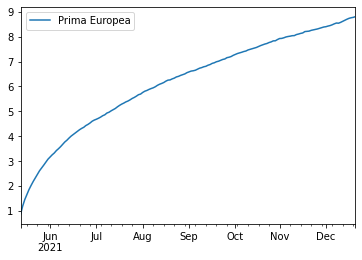

In [105]:
# Valuando opción
strike_4 = S0_4
put_oil = euroPut(r,simul_4,strike_4,expiracion_4)
put_oil.plot()
put_oil.iloc[-1]

### Valuando la opción europea usando Black-Scholes


In [106]:
blackScholesPut(strike_4,S0_4,r,sigma_4,expiracion_4)

9.10176133108586

### Valuación asiática de opción


((7.6219970865202535, 8.215332555343728),
 Prima_asiatica    7.919
 Name: 2021-12-21 00:00:00, dtype: float64)

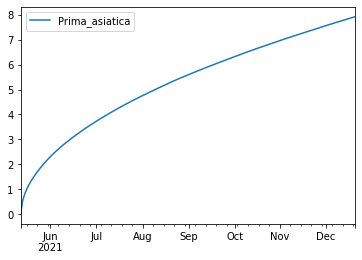

In [107]:
asianPut_4,intervalo_4 = asiaticaPut(strike_4,r*360,S0_4,10000,160,sigma_4*np.sqrt(252),160/360,expiracion_4)
asianPut_4.plot();
intervalo_4,asianPut_4.iloc[-1]

### Valuación Opción Barrera Put

(Prima Down-and-out    5.961
 Name: 2021-12-21 00:00:00, dtype: float64,
 33.154998779296875)

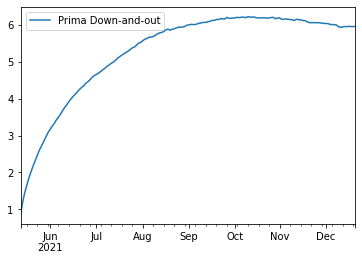

In [113]:
B_4 = S0_4*(1-.5) #50% de pérdidas
barrera_4 = putDownAndOut(r,simul_4,strike_4,expiracion_4,B_4)
barrera_4.plot();
barrera_4.iloc[-1],B_4

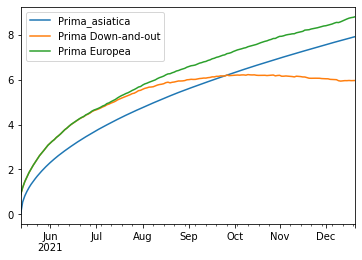

(None, [8.806246831678433, 7.918664820931991, 5.961148511162053])

In [112]:
primas_4 = [float(put_oil.iloc[-1]),float(asianPut_4.iloc[-1]),float(barrera_4.iloc[-1])]

ax = plt.gca()
asianPut_4.plot(ax=ax)
barrera_4.plot(ax=ax)
put_oil.plot(ax=ax)
plt.show(),primas_4

## Recomendación para PEMEX

Para este caso, la opción barrera escogida también es una de tipo put Down-And-Out. La barrera se estableció en 33.15 dólares por barril (25%). El peor escenario que podría ocurrir en caso de contratar opciones sería algo parecido al caso de Abril del 2020, cuando el precio del futuro del barril de petróleo bajó de 0 dólares por barril. Poco probable, pero nos muestra que el precio del barril de petróleo es sumamente volátil en tiempos de crisis como la actual. Se recomienda ampliamente contratar opciones, y la opción más barata en este caso es la opción barrera, con una prima de 5.96 dólares por opción. 

Contratar opciones por un total de 100'000 barriles costaría 596'115 dólares, que representa un 9% del contrato (6'630'900 dólares). El pago de esta prima quedaría completamente saldado si el precio del barril sube de 72.28 dólares por barril.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>